# <h1><center>PROGRAMANDO LA PRIMERA RED NEURONAL</center></h1>

## Importar librerías 
Primero que nada, debemos de importar las librerías que vamos a estar utilizando. Entre éstas se encuentran Keras (librería que permite hacer redes neuronales), Numpy (librería para manipular matrices y arreglos de manera eficiente), así como PyPlot (para graficar datos). 

In [3]:
import numpy as np # Librería para manipular matrices eficientemente
import matplotlib.pyplot as plt # Librería para graficar
from keras.datasets import mnist # Se carga la base de datos con dígitos más popular del mundo: MNIST
from keras.models import Sequential # Vamos a estar utilizando un modelo secuencial
from keras.layers.core import Dense, Activation, Dropout # Importamos tdas las capas que usaremos de la red
from keras.utils import np_utils # Utilidades para manejar datos de tensores con numpy
import random

D:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Definiendo los parámetros iniciales

Se define primero el tamaño de la imagen:

In [4]:
img_width, img_height = 28, 28 # Cada imagen en la base de datos es de 28 x 28 píxeles

Ahora se establece el número de clases que existe en la base de datos. Para este caso, se sabe que existen 10 números o dígitos: 0 - 9.

In [5]:
num_classes = 10

Para que la fase de entrenamiento sea mucho más rápida, se define cada iteración en diferentes lotes de datos. Es decir, para el caso de esta base de datos se tiene un total de 60,000 imágenes, las cuales se dividirán en lotes ó *"batches"* de 128 imágenes cada uno. Por razones teóricas, fundamentadas en el procesamiento digital, siempre se usan lotes que sean potencias de "2". Una iteración de entrenamiento ó *epoch* significa que ya se ingresaron las 60,000 imágenes en la red neuronal para ajustar los parámetros de la misma.

In [6]:
batch_size = 128

Ahora es tiempo de definir el número de iteraciones de entrenamiento.

In [7]:
num_epochs = 10

## Preprocesamiento de los datos

Un paso fundamental en todo proyecto de Machine Learning es verificar las dimensiones de los datos de entrenamiento. La razón radica en el hecho de que se necesitan definir el número de neuronas en cada capa de la red neuronal; para esto, se necesitan saber las dimensiones de las matrices.

In [8]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() #Se obtienen los datos de entrenamiento y validación

In [9]:
print('Dimensiones de los datos de entrenamiento X_train: ', X_train.shape)
print('Dimensiones de los datos de validación X_test: ', X_test.shape)
print('Dimensiones de las etiquetas de entrenamiento Y_train: ', Y_train.shape)
print('Dimensiones de las etiquetas de entrenamiento Y_test: ', Y_test.shape) 

Dimensiones de los datos de entrenamiento X_train:  (60000, 28, 28)
Dimensiones de los datos de validación X_test:  (10000, 28, 28)
Dimensiones de las etiquetas de entrenamiento Y_train:  (60000,)
Dimensiones de las etiquetas de entrenamiento Y_test:  (10000,)


Para que la red neuronal acepte los vectores, se deben de redimensionar de tal manera que queden con las siguientes dimensiones (numero de datos, numero de píxeles)

In [10]:
X_train_reshaped = X_train.reshape(X_train.shape[0], img_width*img_height)
X_test_reshaped = X_test.reshape(X_test.shape[0], img_width*img_height)

print('Dimensiones de los datos de entrenamiento re-dimensionados: ', X_train_reshaped.shape)
print('Dimensiones de los datos de validación re-dimensionados: ', X_test_reshaped.shape)

Dimensiones de los datos de entrenamiento re-dimensionados:  (60000, 784)
Dimensiones de los datos de validación re-dimensionados:  (10000, 784)


Ahora es necesario estructurar los datos de etiquetas para que la red neuronal los acepte. El formato que se define se llama *one-hot vector* lo que significa que se definirá un vector con un número de dimensiones equivalente al número de clases que tengamos en la base de datos. Para este ejemplo, serían los 10 dígitos. En consecuencia, el vector contendrá un "1" en la posición de la clase a la que esté representando y "0" en todas las demás dimensiones.

Ejemplo: las dimensiones del siguiente vector representan a cada dígito. Este vector representa a la etiqueta de una imágen que fue etiquetada como el número *"3"*.       
       
<center>V =( 0   0   0   1   0   0   0   0   0   0) </center>   

In [11]:
Y_train_one_hot = np_utils.to_categorical(Y_train, num_classes) # Se transforma el vector en codificación "one-hot"
Y_test_one_hot = np_utils.to_categorical(Y_test, num_classes) # Se transforma el vector en codificación "one-hot"
print('Representación de la 1° etiqueta de entrenamiento en formato one-hot: ', Y_train_one_hot[0, :]) 

Representación de la 1° etiqueta de entrenamiento en formato one-hot:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Ahora se requiere realizar una normalización de los pixeles. Para esto, se dividen todos los pixeles entre 255. Esto permite tener una escala pixélica entre 0 y 1; evitando así, que la red neuronal ponderé de manera equitativa a todos los píxeles.

In [28]:
X_train_norm = X_train_reshaped.astype('float32') / 255
X_test_norm = X_test_reshaped.astype('float32') / 255

Mostramos algunos ejemplos de las imágenes normalizadas

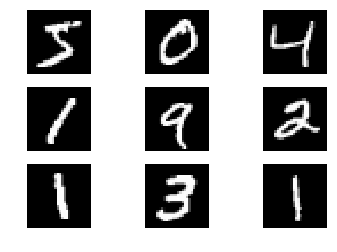

In [29]:
for i in range(9): # Iteramos en 9 imágenes
    plt.subplot(3, 3, i+1) # Creamos una matriz de 3 x 3 imágenes
    plt.imshow(X_train[i, :, :], cmap = 'gray') # Mostramos las primeras 9 imágenes
    plt.axis('off')

## Crear el modelo de la Red Neuronal 

Se definen los parámetros de la arquitectura, tales como el número de neuronas y la probabilidad de desactivación para el regularizador.

In [31]:
num_neurons_input = 500 # Número de neuronas en la capa de entrada
num_neurons_hidden_1 = 250 # Número de neuronas en la 1° capa oculta
num_neurons_hidden_2 = 125 # Número de neuronas en la 2° capa oculta
prob_drop_out = 0.25 # Probabilidad de desactivar neuronas

Se creará una red neuronal con tres capas: la de entradas, la oculta y la de salida. Se usará la función ReLU como función de activación para todas las capas excepto la de salida. Para la capa de salida, se usará una función llamada *softmax*, la cuál es una extensión o generalización de la función sigmoide; usada para estimar múltiples clases.

In [34]:
# Se crea el modelo como un modelo secuencial
model = Sequential() 

# Se añade la capa de entradas
model.add(Dense(units = num_neurons_input, input_dim = img_width*img_height, 
                activation = 'relu', 
                use_bias=True, 
                kernel_initializer='glorot_uniform')) 

# Se añade un regularizador para evitar sobreajuste de curvas
model.add(Dropout(prob_drop_out))

# Se añade la 1° capa oculta 
model.add(Dense(units = num_neurons_hidden_1, activation = 'relu', 
                use_bias=True, 
                kernel_initializer='glorot_uniform'))

# Se añade un regularizador para evitar sobreajuste de curvas
model.add(Dropout(prob_drop_out))

# Se añade la 2° capa oculta 
model.add(Dense(units = num_neurons_hidden_2, activation = 'relu', 
                use_bias=True, 
                kernel_initializer='glorot_uniform'))

# Se añade la capa de salidas
model.add(Dense(units = num_classes, activation = 'softmax')) 

Se compila el modelo. Se usa un descenso por gradiente esocástico para optimizar la función de costo de pérdida logarítmica.Y se define precisión como métrica de evaluación

In [35]:
model.compile(loss='categorical_crossentropy', optimizer= 'sgd', metrics = ['accuracy'])

## Entrenamiento de la Red Neuronal 

Se define el entrenamiento de la red neuronal con todos los parámetros que hemos definido hasta ahora.

In [36]:
history = model.fit(X_train_norm, Y_train_one_hot, batch_size=batch_size, 
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=(X_test_norm, Y_test_one_hot))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 75us/step - loss: 1.3400 - acc: 0.6213 - val_loss: 0.5154 - val_acc: 0.8722
Epoch 2/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.5593 - acc: 0.8344 - val_loss: 0.3585 - val_acc: 0.8997
Epoch 3/10
60000/60000 [==============================] - 3s 44us/step - loss: 0.4401 - acc: 0.8687 - val_loss: 0.3063 - val_acc: 0.9112
Epoch 4/10
60000/60000 [==============================] - 3s 42us/step - loss: 0.3791 - acc: 0.8880 - val_loss: 0.2749 - val_acc: 0.9183
Epoch 5/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.3439 - acc: 0.8980 - val_loss: 0.2509 - val_acc: 0.9270
Epoch 6/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.3164 - acc: 0.9075 - val_loss: 0.2317 - val_acc: 0.9331
Epoch 7/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.2898 - acc: 0.9138 - val_loss: 0.2177 - val_acc

## Resultados de entrenamiento

Se grafica la precisión obtenida en cada iteración del entrenamiento. Se debe siempre analizar para los datos de entrenamiento y los datos de validación.

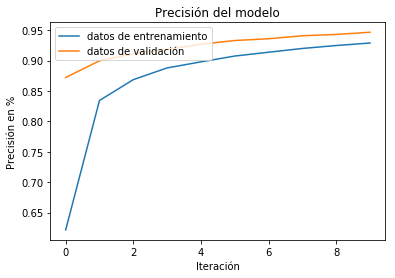

In [37]:
# summarize history for accuracy
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión en %')
plt.xlabel('Iteración')
plt.legend(['datos de entrenamiento', 'datos de validación'], loc='upper left')
plt.show()

## Clasificando dígitos

Se clasifican 9 números aleatorios del conjunto de datos de validación.

9/9 [==============================] - 0s 332us/step


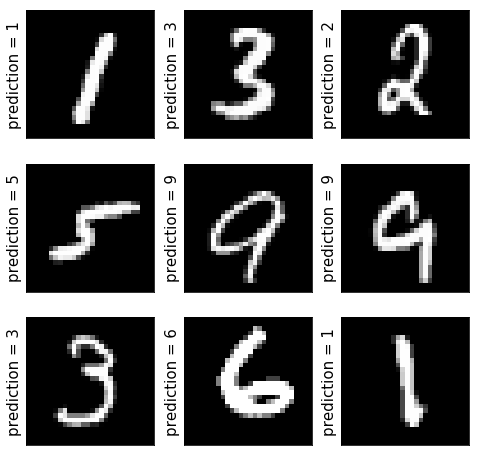

In [40]:
random_index = random.randint(0, np.round(X_test_norm.shape[0]/ 2))
predictions = model.predict_classes(X_test_norm[random_index:random_index+9]) # Se realizan las predicciones
plt.figure(figsize=(8, 8)) # Se crea la figura para graficar
i = 0

for i in range(random_index, random_index+9):
    plt.subplot(3, 3, i+1-random_index)
    plt.imshow(X_test[i], cmap='gray')
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel("prediction = %d" % predictions[i - random_index], fontsize = 15)
